<a href="https://colab.research.google.com/github/CarlottaVattolo/Esame/blob/main/Studenti_NetworkFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Network Flow Problems

In [ ]:
!pip3 install gurobipy
!pip3 install ortools

## Multi-Commodity Network Flow w/Gurobi

We have two products, 'Pencils' and 'Pens', that are produced in two cities, 'Denver' and 'Detroit'. Our goal is to minimize the cost of delivering them to 'Boston', 'New York' and 'Seattle' in order to satify their demand. 
\begin{align}
  \text{minimize} &\sum_{pij} c_{pij}\times f_{pij}\\
            &s.t.\\
            \sum_p f_{pij} &\leq h_{ij},\ \forall\ i, j \in \text{Arcs}\\
            \sum_{i} f_{pij} + b_{pj} &== \sum_{i} f_{pij}, \forall p, \forall j
\end{align}
where $c_{pij}$ is the cost of transporting one unit of commodity $p$ from $i$ to $j$, while $f_{pij}$ is the transported quantity, $h_{ij}$ the capacity of the connection and $b_{pj}$ the inflow in $j$.

In [ ]:
import gurobipy as gp
from gurobipy import GRB

Define the commodities and cities

In [ ]:
commodities = ['Pencils', 'Pens']
nodes = ['Denver', 'Detroit', 'Boston', 'New York', 'Seattle']

Define the arcs and their capacity, $h_{ij}$, using the multidict in gurobipy (https://www.gurobi.com/documentation/9.5/refman/py_multidict.html)

In [ ]:
# EXAMPLE of multidict usage:
keys, dict1, dict2, dict3 = gp.multidict({'key1': ('a', 'b', 'c'), 'key2': ('x', 'y', 'z')})
print(f"Keys: {keys}\nDict1: {dict1}\nDict2: {dict2}\nDict3: {dict3}")

In [ ]:
arcs, capacity = gp.multidict({('Denver', 'Boston'): 120,
                                 ('Denver', 'New York'): 120,
                                 ('Denver', 'Seattle'): 120,
                                 ('Detroit', 'Boston'): 100,
                                 ('Detroit', 'New York'): 80,
                                 ('Detroit', 'Seattle'): 120})
print(f'Arcs: {arcs}\n Capacities: {capacity}')

Define costs for commodities-source-destination triplets, $c_{pij}$

In [ ]:
cost = {
    ('Pencils', 'Detroit', 'Boston'):   10,
    ('Pencils', 'Detroit', 'New York'): 20,
    ('Pencils', 'Detroit', 'Seattle'):  60,
    ('Pencils', 'Denver',  'Boston'):   40,
    ('Pencils', 'Denver',  'New York'): 40,
    ('Pencils', 'Denver',  'Seattle'):  30,
    ('Pens',    'Detroit', 'Boston'):   20,
    ('Pens',    'Detroit', 'New York'): 20,
    ('Pens',    'Detroit', 'Seattle'):  80,
    ('Pens',    'Denver',  'Boston'):   60,
    ('Pens',    'Denver',  'New York'): 70,
    ('Pens',    'Denver',  'Seattle'):  30}

Define the demands, $b_{pi}$, of each commodity for each city

In [ ]:
inflow = {
    ('Pencils', 'Detroit'):   50,
    ('Pencils', 'Denver'):    60,
    ('Pencils', 'Boston'):   -50,
    ('Pencils', 'New York'): -50,
    ('Pencils', 'Seattle'):  -10,
    ('Pens',    'Detroit'):   60,
    ('Pens',    'Denver'):    40,
    ('Pens',    'Boston'):   -40,
    ('Pens',    'New York'): -30,
    ('Pens',    'Seattle'):  -30}

Create the model, add the variables using addVars (https://www.gurobi.com/documentation/9.5/refman/py_model_addvars.html) and set the objective function coefficients using the cost dictionary:
$$\min \sum_{p, i, j} c_{pij}\times f_{pij}$$

In [ ]:
m = gp.Model('netflow')
flow = m.addVars(commodities, arcs, obj=cost, name='flow')
m.update()
print(f"Model variables: {m.getVars()}")

In [ ]:
print(f"flow: {flow}")
print(f"flow['Pencils', 'Denver', 'New York']: {flow['Pencils', 'Denver', 'New York']}")

Add capacity constraints for each arc:
$$\sum_p f_{pij} \leq h_{ij},\ \forall\ i, j \in \text{Arcs}$$

Using the `tupledict.sum` method (https://www.gurobi.com/documentation/9.5/refman/py_tupledict_sum.html), we specify a pattern representing the variables to sum in the tuplecit. In this case, for the arc represented by cities `i` and `j` we sum over all the commodities (represented by the `'*'`):



In [ ]:
m.addConstrs((flow.sum('*', i, j) <= capacity[i, j] for i, j in arcs), "cap")

Add the flow conservation constraints:
$$\sum_{i} f_{pij} + b_{pj} == \sum_{i} f_{pij}, \forall p, \forall j$$

In [ ]:
m.addConstrs((flow.sum(h, '*', j) + inflow[h, j] == flow.sum(h, j, '*') for h in commodities for j in nodes), "node")

Solve the problem and visualize the solution

In [ ]:
m.optimize()

# Print solution
if m.Status == GRB.OPTIMAL:
    solution = m.getAttr('X', flow)
    for h in commodities:
        print('\nOptimal flows for %s:' % h)
        for i, j in arcs:
            if solution[h, i, j] > 0:
                print('%s -> %s: %g' % (i, j, solution[h, i, j]))

## Minimum Flow w/OR-Tools

In [ ]:
from ortools.graph import pywrapgraph

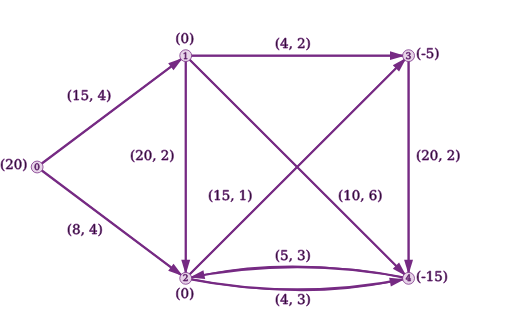

Define the solver using `pywrapgraph.SimpleMinCostFlow` (https://developers.google.com/optimization/reference/python/graph/pywrapgraph#simplemincostflow)

In [ ]:
min_cost_flow = pywrapgraph.SimpleMinCostFlow()

Define the arcs in the graph specifing start and end nodes

In [ ]:
start_nodes = [0, 0, 1, 1, 1, 2, 2, 3, 4]
end_nodes = [1, 2, 2, 3, 4, 3, 4, 4, 2]

Set the capacities and costs for each arc

In [ ]:
capacities = [15, 8, 20, 4, 10, 15, 4, 20, 5]
unit_costs = [4, 4, 2, 2, 6, 1, 3, 2, 3]

Set the suplies for each node

In [ ]:
supplies = [20, 0, 0, -5, -15]

Add the arcs and supply nodes to the solver

In [ ]:
for arc in zip(start_nodes, end_nodes, capacities, unit_costs):
    min_cost_flow.AddArcWithCapacityAndUnitCost(arc[0], arc[1], arc[2],
                                                arc[3])

for count, supply in enumerate(supplies):
    min_cost_flow.SetNodeSupply(count, supply)

Solve the problem and print the solution

In [ ]:
status = min_cost_flow.Solve()

if status != min_cost_flow.OPTIMAL:
    print('There was an issue with the min cost flow input.')
    print(f'Status: {status}')
    exit(1)
print('Minimum cost: ', min_cost_flow.OptimalCost())
print('')
print(' Arc   Flow / Capacity  Cost')
for i in range(min_cost_flow.NumArcs()):
    cost = min_cost_flow.Flow(i) * min_cost_flow.UnitCost(i)
    print('%1s -> %1s    %3s   / %3s   %3s' %
          (min_cost_flow.Tail(i), min_cost_flow.Head(i),
           min_cost_flow.Flow(i), min_cost_flow.Capacity(i), cost))

## Max Flow problem w/OR-Tools

Using the SimpleMinCostFlow solver, solve the following max flow problem

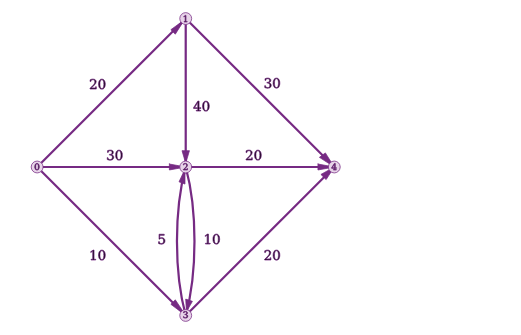

Define the solver, start and end nodes

In [ ]:
from ortools.graph import pywrapgraph
min_cost_flow = ...
start_nodes = ...
end_nodes = ...

Define the capacities, unit costs and supplies

In [ ]:
capacities = ...
unit_costs = ...
supplies = ...

Add arcs and nodes to the solver

In [ ]:
...

Solve the problem and print the solution

In [ ]:
status = min_cost_flow.Solve()

if status != min_cost_flow.OPTIMAL:
    print('There was an issue with the min cost flow input.')
    print(f'Status: {status}')
    exit(1)
print('Minimum cost: ', min_cost_flow.OptimalCost())
print('')
print(' Arc   Flow / Capacity  Cost')
for i in range(min_cost_flow.NumArcs()):
    cost = min_cost_flow.Flow(i) * min_cost_flow.UnitCost(i)
    print('%1s -> %1s    %3s   / %3s   %3s' %
          (min_cost_flow.Tail(i), min_cost_flow.Head(i),
           min_cost_flow.Flow(i), min_cost_flow.Capacity(i), cost))

### Lets do the same with the `SimpleMaxFlow` solver

In [ ]:
from ortools.graph import pywrapgraph
max_flow = pywrapgraph.SimpleMaxFlow()
start_nodes = [0, 0, 0, 1, 1, 2, 2, 3, 3]
end_nodes = [1, 2, 3, 2, 4, 3, 4, 2, 4]
capacities = [20, 30, 10, 40, 30, 10, 20, 5, 20]


Add arcs with capacity

In [ ]:
for arc in zip(start_nodes, end_nodes, capacities):
    max_flow.AddArcWithCapacity(arc[0], arc[1], arc[2])


Solve and print the solution

In [ ]:
status = max_flow.Solve(0, 4) #Here we need to specify the source and sink nodes

if status != max_flow.OPTIMAL:
    print('There was an issue with the max flow input.')
    print(f'Status: {status}')
    exit(1)
print('Max flow:', max_flow.OptimalFlow())
print('')
print('  Arc    Flow / Capacity')
for i in range(max_flow.NumArcs()):
    print('%1s -> %1s   %3s  / %3s' %
          (max_flow.Tail(i), max_flow.Head(i), max_flow.Flow(i),
           max_flow.Capacity(i)))
print('Source side min-cut:', max_flow.GetSourceSideMinCut())
print('Sink side min-cut:', max_flow.GetSinkSideMinCut())

## Assignment as Minimum Cost Flow

Using the min cost flow solver, solve an assignment problem with 4 workers, 4 tasks and the following cost matrix:
\begin{array}{|c|c|c|c|}\hline
   & T1 & T2 & T3 & T4\\ \hline
W1 & 90 & 76 & 75 & 70\\ \hline
W2 & 35 & 85 & 55 & 65\\ \hline
W3 & 125& 95 &  90 & 105\\ \hline
W4 & 45 & 10 &  95 & 115\\ \hline 
\end{array}


Define the solver and the arcs

In [ ]:
from ortools.graph import pywrapgraph
min_cost_flow = ...

In [ ]:
start_nodes = ...
end_nodes = ...

Define the capacities and costs

In [ ]:
capacities = ...
costs = ...

Define the supplies, source and sink nodes

In [ ]:
source = ...
sink = ...
supplies = ...

Add the arcs to the solver

In [ ]:
...

Set the nodes supplies

In [ ]:
...

Solve the problem

In [ ]:
status = min_cost_flow.Solve()

Print the solution

In [ ]:
if status == min_cost_flow.OPTIMAL:
    print('Total cost = ', min_cost_flow.OptimalCost())
    print()
    for arc in range(min_cost_flow.NumArcs()):
        # Can ignore arcs leading out of source or into sink.
        if min_cost_flow.Tail(arc) != source and min_cost_flow.Head(
                arc) != sink:

            # Arcs in the solution have a flow value of 1. Their start and end nodes
            # give an assignment of worker to task.
            if min_cost_flow.Flow(arc) > 0:
                print('Worker %d assigned to task %d.  Cost = %d' %
                      (min_cost_flow.Tail(arc), min_cost_flow.Head(arc),
                       min_cost_flow.UnitCost(arc)))
else:
    print('There was an issue with the min cost flow input.')
    print(f'Status: {status}')